<a href="https://colab.research.google.com/github/Asal-Sanei/MachineLearning2025/blob/main/Mini%20Project%204/MP4_Question3_WampusWorld_FinalEdit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import deque

# --- Wumpus World Environment ---
class GridEnvironment:
    def __init__(self):
        self.grid_size = 4
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.agent_position = [0, 0]  # Starting position of the agent
        self.gold_position = [3, 3]  # Position of the gold
        self.pits = [[1, 1], [2, 2]]  # Positions of the pits
        self.wumpus_position = [1, 3]  # Position of the Wumpus
        self.wumpus_alive = True  # status of the Wumpus
        self.arrow_available = True  # Status of the arrow
        self.deaths = 0 #  death counter

        # Setting up the grid
        self.grid[self.gold_position[0], self.gold_position[1]] = 1  # Gold
        for pit in self.pits:
            self.grid[pit[0], pit[1]] = -1  # Pits
        self.grid[self.wumpus_position[0], self.wumpus_position[1]] = -2  # Wumpus

    def reset(self):
        self.agent_position = [0, 0]
        self.wumpus_position = [1, 3]
        self.wumpus_alive = True
        self.arrow_available = True
        self.deaths = 0
        return tuple(self.agent_position)

    def step(self, action):
        reward = -1  # Movement penalty
        done = False

        if action == 'up':
            self.agent_position[0] = max(0, self.agent_position[0] - 1)
        elif action == 'down':
            self.agent_position[0] = min(self.grid_size - 1, self.agent_position[0] + 1)
        elif action == 'left':
            self.agent_position[1] = max(0, self.agent_position[1] - 1)
        elif action == 'right':
            self.agent_position[1] = min(self.grid_size - 1, self.agent_position[1] + 1)
        elif action == 'shoot_up' and self.arrow_available:
            # Shoot the arrow upwards
            if self.wumpus_position[0] < self.agent_position[0] and self.wumpus_position[1] == self.agent_position[1]:
                reward = 50
                self.wumpus_alive = False
            self.arrow_available = False
        elif action == 'shoot_down' and self.arrow_available:
            # Shoot the arrow downwards
            if self.wumpus_position[0] > self.agent_position[0] and self.wumpus_position[1] == self.agent_position[1]:
                reward = 50
                self.wumpus_alive = False
            self.arrow_available = False
        elif action == 'shoot_left' and self.arrow_available:
            # Shoot the arrow to the left
            if self.wumpus_position[1] < self.agent_position[1] and self.wumpus_position[0] == self.agent_position[0]:
                reward = 50
                self.wumpus_alive = False
            self.arrow_available = False
        elif action == 'shoot_right' and self.arrow_available:
            # Shoot the arrow to the right
            if self.wumpus_position[1] > self.agent_position[1] and self.wumpus_position[0] == self.agent_position[0]:
                reward = 50
                self.wumpus_alive = False
            self.arrow_available = False

        # Check if the game has ended
        if self.agent_position == self.gold_position:
            reward = 100  # Reward for finding the gold
            done = True
        elif self.agent_position in self.pits:
            reward = -1000  # Penalty for falling into a pit
            done = True
            self.deaths += 1 # Increment death counter
        elif self.agent_position == self.wumpus_position and self.wumpus_alive:
            reward = -1000 # Penalty for encountering a live Wumpus
            done = True
            self.deaths += 1 # Increment death counter

        return tuple(self.agent_position), reward, done

    def get_possible_actions(self):
        return ['up', 'down', 'left', 'right', 'shoot_up', 'shoot_down', 'shoot_left', 'shoot_right']

#Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.q_table = {}  #  Q-table as an empty dictionary
        self.learning_rate = learning_rate  # Learning rate
        self.discount_factor = discount_factor  # Discount factor
        self.exploration_rate = exploration_rate  # Initial exploration rate for epsilon-greedy policy
        self.exploration_decay = exploration_decay  # Decay rate for exploration rate

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.env.get_possible_actions(), key=lambda a: self.get_q_value(next_state, a))

        td_target = reward + self.discount_factor * self.get_q_value(next_state, best_next_action)

        td_error = td_target - self.get_q_value(state, action)

        new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error

        self.q_table[(state, action)] = new_q_value

    def choose_action(self, state):
        # Choose an action using epsilon-greedy policy
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(self.env.get_possible_actions())  # Explore: choose a random action
        else:
            return max(self.env.get_possible_actions(), key=lambda a: self.get_q_value(state, a))  # Exploit: choose the best action

    def train(self, episodes):
        total_rewards = []
        episode_deaths = []
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            self.env.deaths = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
            total_rewards.append(total_reward)
            episode_deaths.append(self.env.deaths)
            self.exploration_rate *= self.exploration_decay
        return total_rewards, episode_deaths

# --- Replay Memory (for DQN) ---
class ReplayMemory:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.states = np.zeros((capacity,) + state_shape, dtype=np.float32)
        self.actions = np.zeros(capacity, dtype=np.int32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity,) + state_shape, dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.bool_)
        self.index = 0 # Current index for storing new experiences
        self.current_size = 0 # Current number of experiences stored

    def store(self, state, action, reward, next_state, done):
        # Store a new memory of an experience
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = done
        self.index = (self.index + 1) % self.capacity
        self.current_size = min(self.current_size + 1, self.capacity)

    def sample(self, batch_size):
        # Randomly sample a batch of experiences from memory
        indices = np.random.choice(self.current_size, batch_size, replace=False)
        return (self.states[indices], self.actions[indices], self.rewards[indices],
                self.next_states[indices], self.dones[indices])

# --- Plotting Function ---
def plot_rewards(total_rewards, cumulative_rewards, mean_rewards, title, filename):
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))

    # Plot Total Reward per Episode
    axs[0].plot(total_rewards, label='Total Reward', color='blue', linestyle='-', linewidth=0.8)
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode ({title})')
    axs[0].legend()
    axs[0].grid(True)
    if total_rewards:
        axs[0].annotate(f'Last value: {total_rewards[-1]}', xy=(len(total_rewards)-1, total_rewards[-1]),
                     xytext=(len(total_rewards)-1, total_rewards[-1]), textcoords='data',
                     arrowprops=dict(arrowstyle='->', color='blue'))

    # Plot Cumulative Reward per Episode
    axs[1].plot(cumulative_rewards, label='Cumulative Reward', color='green', linestyle='-', linewidth=0.8)
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Cumulative Reward')
    axs[1].set_title(f'Cumulative Reward per Episode ({title})')
    axs[1].legend()
    axs[1].grid(True)
    if cumulative_rewards:
        axs[1].annotate(f'Last value: {cumulative_rewards[-1]}', xy=(len(cumulative_rewards)-1, cumulative_rewards[-1]),
                     xytext=(len(cumulative_rewards)-1, cumulative_rewards[-1]), textcoords='data',
                     arrowprops=dict(arrowstyle='->', color='green'))

    # Plot Mean Reward per Episode
    axs[2].plot(mean_rewards, label='Mean Reward', color='red', linestyle='-', linewidth=0.8)
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Mean Reward')
    axs[2].set_title(f'Mean Reward per Episode ({title})')
    axs[2].legend()
    axs[2].grid(True)
    if mean_rewards:
        axs[2].annotate(f'Last value: {mean_rewards[-1]}', xy=(len(mean_rewards)-1, mean_rewards[-1]),
                     xytext=(len(mean_rewards)-1, mean_rewards[-1]), textcoords='data',
                     arrowprops=dict(arrowstyle='->', color='red'))

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def plot_rewards_comparison(q_learning_total_rewards, q_learning_cumulative_rewards, q_learning_mean_rewards,
                            dqn_total_rewards, dqn_cumulative_rewards, dqn_mean_rewards, title, filename):
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))

    # Plot Total Reward per Episode
    axs[0].plot(q_learning_total_rewards, label='Q-Learning Total Reward', color='tab:purple')
    axs[0].plot(dqn_total_rewards, label='DQN Total Reward', color='tab:brown')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode ({title})')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Cumulative Reward per Episode
    axs[1].plot(q_learning_cumulative_rewards, label='Q-Learning Cumulative Reward', color='tab:green')
    axs[1].plot(dqn_cumulative_rewards, label='DQN Cumulative Reward', color='tab:red')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Cumulative Reward')
    axs[1].set_title(f'Cumulative Reward per Episode ({title})')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Mean Reward per Episode
    axs[2].plot(q_learning_mean_rewards, label='Q-Learning Mean Reward', color='tab:purple')
    axs[2].plot(dqn_mean_rewards, label='DQN Mean Reward', color='tab:brown')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Mean Reward')
    axs[2].set_title(f'Mean Reward per Episode ({title})')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()




--- Training Q-Learning Agent ---


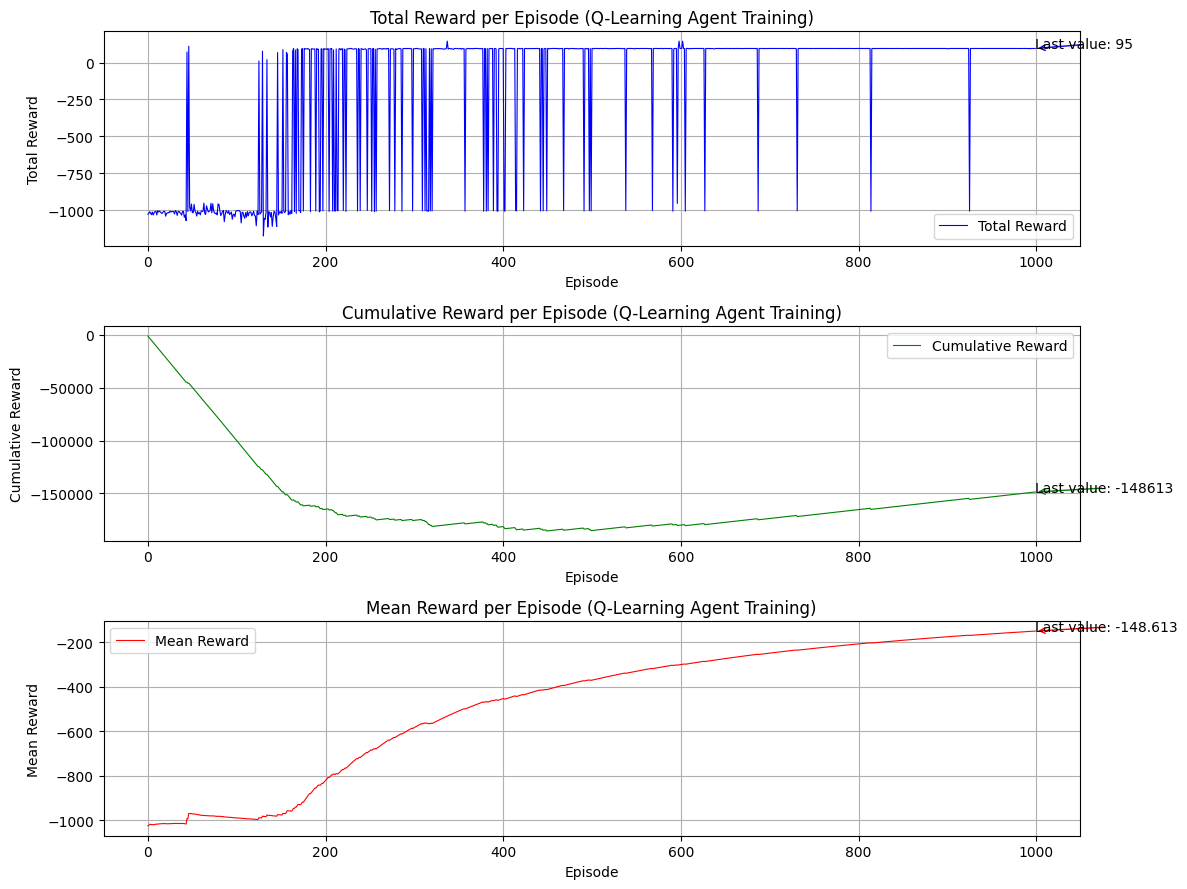


=== Q-Learning Training Summary ===
Number of Deaths: 219
Total Rewards : -148613
Highest Reward : 145
Lowest Reward : -1173


In [ ]:
# --- Example Usage ---

if __name__ == "__main__":
    # Initialize environment
    env = GridEnvironment()

    # --- Q-Learning Training ---
    print("--- Training Q-Learning Agent ---")
    q_agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995)
    q_episodes = 1000
    q_total_rewards, q_episode_deaths = q_agent.train(q_episodes)

    # Calculate cumulative and mean rewards for Q-learning
    q_cumulative_rewards = [np.sum(q_total_rewards[:i+1]) for i in range(len(q_total_rewards))]
    q_mean_rewards = [np.mean(q_total_rewards[:i+1]) for i in range(len(q_total_rewards))]

    # Plot Q-Learning results
    plot_rewards(q_total_rewards, q_cumulative_rewards, q_mean_rewards, "Q-Learning Agent Training", "q_learning_rewards.png")

    print("\n=== Q-Learning Training Summary ===")
    print(f"Number of Deaths: {np.sum(q_episode_deaths)}")
    print(f"Total Rewards : {np.sum(q_total_rewards)}")
    print(f"Highest Reward : {np.max(q_total_rewards)}")
    print(f"Lowest Reward : {np.min(q_total_rewards)}")


--- Training Q-Learning Agent ---


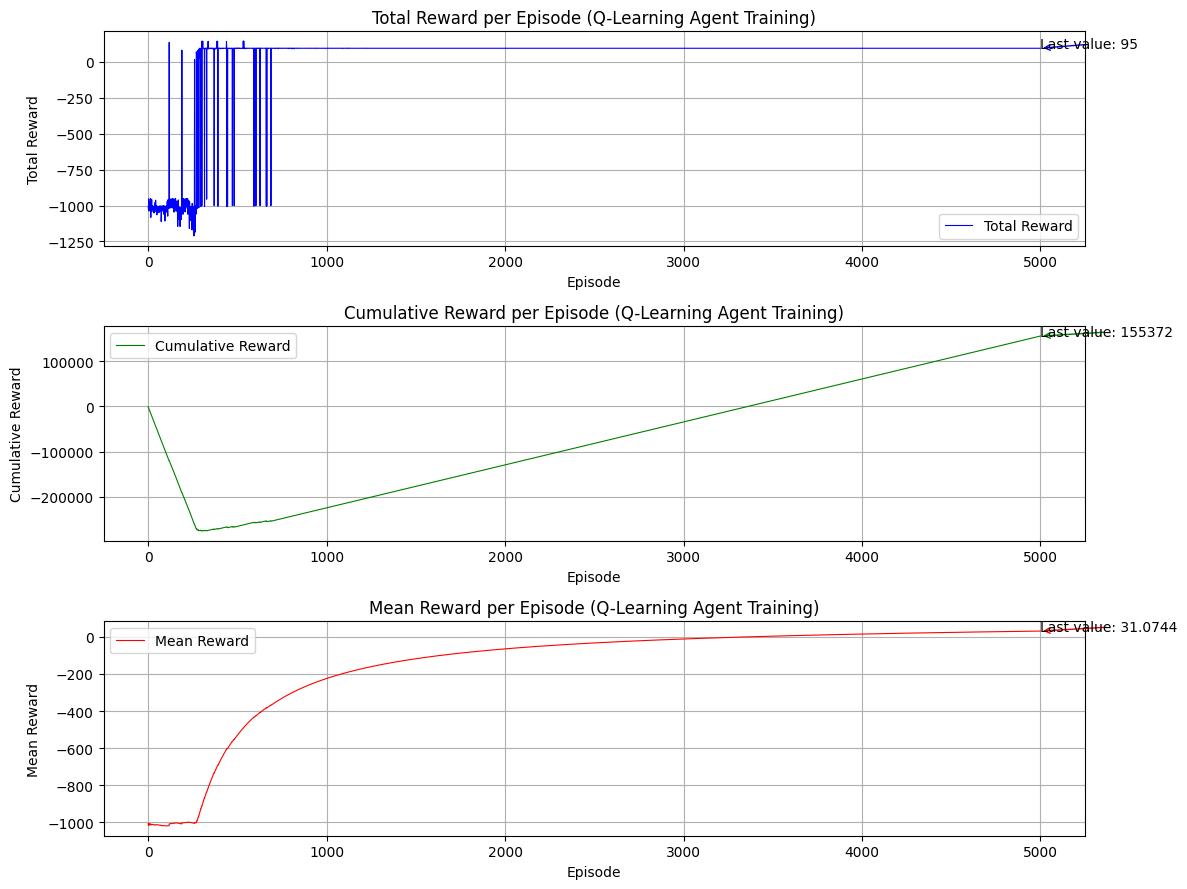


=== Q-Learning Training Summary ===
Number of Deaths: 288
Total Rewards : 155372
Highest Reward : 145
Lowest Reward : -1212


In [ ]:
# prompt: 5000 episode for Q  learning

# --- Example Usage ---

if __name__ == "__main__":
    # Initialize environment
    env = GridEnvironment()

    # --- Q-Learning Training ---
    print("--- Training Q-Learning Agent ---")
    q_agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995)
    q_episodes = 5000  # Set the number of episodes to 5000
    q_total_rewards, q_episode_deaths = q_agent.train(q_episodes)

    # Calculate cumulative and mean rewards for Q-learning
    q_cumulative_rewards = [np.sum(q_total_rewards[:i+1]) for i in range(len(q_total_rewards))]
    q_mean_rewards = [np.mean(q_total_rewards[:i+1]) for i in range(len(q_total_rewards))]

    # Plot Q-Learning results
    plot_rewards(q_total_rewards, q_cumulative_rewards, q_mean_rewards, "Q-Learning Agent Training", "q_learning_rewards.png")

    print("\n=== Q-Learning Training Summary ===")
    print(f"Number of Deaths: {np.sum(q_episode_deaths)}")
    print(f"Total Rewards : {np.sum(q_total_rewards)}")
    print(f"Highest Reward : {np.max(q_total_rewards)}")
    print(f"Lowest Reward : {np.min(q_total_rewards)}")



#DQN

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.losses import Huber

##GridEnvironment

In [ ]:
class GridEnvironment:
    def __init__(self):
        self.size = 4
        self.grid = np.zeros((self.size, self.size))  # Initialize grid
        self.agent_pos = (0, 0)  # Starting position of the agent
        self.gold_pos = (3, 3)  # Position where the gold is located
        self.wumpus_pos = (1, 3)  # Position of a dangerous creature, Wumpus
        self.pits = [(1, 1), (2, 2)]  # Positions of hazardous pits
        self.arrow_available = True  # Availability of an arrow for the agent
        self.wumpus_alive = True  # Initial state of Wumpus (alive)
        self.reset()

    def reset(self):
        # Reset the game state to the initial configuration
        self.agent_pos = (0, 0)
        self.arrow_available = True
        self.wumpus_alive = True
        return self.get_state()

    def step(self, action):
        # Calculate the result of the agent's action
        x, y = self.agent_pos
        reward = -1  # Default reward for a movement
        done = False

        # Define movements and actions
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4 and self.arrow_available:  # Shoot arrow upwards
            self.arrow_available = False
            if any(self.wumpus_pos == (i, y) for i in range(x)):
                reward = 50  # Reward for killing Wumpus
                self.wumpus_alive = False
        elif action == 5 and self.arrow_available:  # Shoot arrow downwards
            self.arrow_available = False
            if any(self.wumpus_pos == (i, y) for i in range(x+1, self.size)):
                reward = 50
                self.wumpus_alive = False
        elif action == 6 and self.arrow_available:  # Shoot arrow leftwards
            self.arrow_available = False
            if any(self.wumpus_pos == (x, j) for j in range(y)):
                reward = 50
                self.wumpus_alive = False
        elif action == 7 and self.arrow_available:  # Shoot arrow rightwards
            self.arrow_available = False
            if any(self.wumpus_pos == (x, j) for j in range(y+1, self.size)):
                reward = 50
                self.wumpus_alive = False

        # Update agent's position
        self.agent_pos = (x, y)

        # Check for game-ending conditions
        if self.agent_pos == self.gold_pos:
            reward = 100  # Reward for finding gold
            done = True
        elif self.agent_pos in self.pits:
            reward = -1000  # Penalty for falling into a pit
            done = True
        elif self.agent_pos == self.wumpus_pos and self.wumpus_alive:
            reward = -1000  # Penalty for encountering a live Wumpus
            done = True

        return self.get_state(), reward, done

    def get_state(self):
        # Represent the current state as a vector
        state = np.zeros((self.size, self.size, 5))
        state[self.agent_pos][0] = 1  # Agent's position
        state[self.gold_pos][1] = 1  # Gold's position
        for pit in self.pits:
            state[pit][3] = 1  # Pits' positions
        state[:,:,4] = int(self.arrow_available)
        return state.flatten()

##ReplayMemory

In [ ]:
class ReplayMemory:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.states = np.zeros((capacity,) + state_shape, dtype=np.float32)
        self.actions = np.zeros(capacity, dtype=np.int32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity,) + state_shape, dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.bool_)
        self.index = 0
        self.current_size = 0

    def store(self, state, action, reward, next_state, done):
        # Store a new memory of an experience
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = done
        self.index = (self.index + 1) % self.capacity
        self.current_size = min(self.current_size + 1, self.capacity)

    def sample(self, batch_size):
        # Randomly sample a batch of experiences from memory
        indices = np.random.choice(self.current_size, batch_size, replace=False)
        return (self.states[indices], self.actions[indices], self.rewards[indices],
                self.next_states[indices], self.dones[indices])

##class DQNAgent

In [ ]:
class DQNAgent:
    def __init__(self, learning_rate, gamma, state_shape, num_actions, batch_size,
                 epsilon_initial=1.0, epsilon_decay=0.995, epsilon_final=0.05,
                 replay_buffer_capacity=1000):
        self.learning_rate = learning_rate  # Learning rate for optimization
        self.gamma = gamma  # Discount factor for future rewards
        self.num_actions = num_actions  # Number of possible actions
        self.batch_size = batch_size  # Batch size for training
        self.epsilon = epsilon_initial  # Initial probability for random actions
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_final = epsilon_final  # Minimum value for epsilon
        self.buffer = ReplayMemory(replay_buffer_capacity, state_shape)
        self.q_network = self._build_model(state_shape, num_actions)
        self.target_network = self._build_model(state_shape, num_actions)
        self.update_target_network()

    def _build_model(self, state_shape, num_actions):
        model = keras.Sequential([
            keras.layers.Dense(128, activation='relu', input_shape=state_shape),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(num_actions, activation=None)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss=Huber())
        return model

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.num_actions)
        else:
            q_values = self.q_network.predict(state[np.newaxis])
            action = np.argmax(q_values[0])
        return action

    def train(self, env, episodes):
        total_rewards, cumulative_rewards = [], []
        for episode in range(episodes):
            state = env.reset()
            done, total_reward = False, 0
            while not done:
                action = self.select_action(state)
                next_state, reward, done = env.step(action)
                self.buffer.store(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                if self.buffer.current_size >= self.batch_size:
                    self.replay()

            self.update_epsilon()
            self.update_target_network()
            total_rewards.append(total_reward)
            cumulative_rewards.append(total_reward if not cumulative_rewards else cumulative_rewards[-1] + total_reward)
            print(f'Episode {episode+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon}')

        mean_rewards = np.cumsum(total_rewards) / (np.arange(len(total_rewards)) + 1)
        self.save_rewards_data(total_rewards, cumulative_rewards, mean_rewards)

        print("\n=== Training Summary ===")
        print(f"Number of Deaths : {sum(r < 0 for r in total_rewards)}")
        print(f"Total Rewards    : {sum(total_rewards)}")
        print(f"Highest Reward   : {max(total_rewards)}")
        print(f"Lowest Reward    : {min(total_rewards)}")
        print(f"Accuracy         : {sum(r > 0 for r in total_rewards) / len(total_rewards) * 100:.2f}%")
        print("========================\n")

        return total_rewards, cumulative_rewards, mean_rewards

    def replay(self):
        if self.buffer.current_size < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        q_values_current = self.q_network.predict(states)
        q_values_next = self.target_network.predict(next_states)

        # Update Q-values
        targets = q_values_current.copy()
        batch_indices = np.arange(self.batch_size, dtype=np.int32)
        targets[batch_indices, actions] = rewards + self.gamma * np.amax(q_values_next, axis=1) * (1 - dones)

        self.q_network.train_on_batch(states, targets)

    def update_epsilon(self):
        # Decay epsilon
        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

    def save_rewards_data(self, total_rewards, cumulative_rewards, mean_rewards):
        data = {
            "Episode": np.arange(len(total_rewards)),
            "Total Reward": total_rewards,
            "Cumulative Reward": cumulative_rewards,
            "Mean Reward": mean_rewards
        }

        df = pd.DataFrame(data)
        df.to_csv("dqn_training_rewards.csv", index=False)

    def save_model(self, model_path):
        self.q_network.save(model_path)

    def load_model(self, model_path):
        self.q_network = keras.models.load_model(model_path)
        self.update_target_network()

def plot_rewards(total_rewards, cumulative_rewards, mean_rewards, title, filename):
    fig, axs = plt.subplots(3, 1, figsize=(10, 7))

    total_color = '#377eb8'
    cumulative_color = '#4daf4a'
    mean_color = '#ff7f00'

    axs[0].plot(total_rewards, label='Total Reward', color=total_color )
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode ({title})')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].annotate(f'Last value: {total_rewards[-1]}', xy=(len(total_rewards)-1, total_rewards[-1]),
                    xytext=(len(total_rewards)-10, total_rewards[-1] + 5), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color=total_color))

    axs[1].plot(cumulative_rewards, label='Cumulative Reward', color=cumulative_color)
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Cumulative Reward')
    axs[1].set_title(f'Cumulative Reward per Episode ({title})')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].annotate(f'Last value: {cumulative_rewards[-1]}', xy=(len(cumulative_rewards)-1, cumulative_rewards[-1]),
                    xytext=(len(cumulative_rewards)-10, cumulative_rewards[-1] + 5), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color=cumulative_color))

    axs[2].plot(mean_rewards, label='Mean Reward', color=mean_color)
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Mean Reward')
    axs[2].set_title(f'Mean Reward per Episode ({title})')
    axs[2].legend()
    axs[2].grid(True)
    axs[2].annotate(f'Last value: {mean_rewards[-1]}', xy=(len(mean_rewards)-1, mean_rewards[-1]),
                    xytext=(len(mean_rewards)-10, mean_rewards[-1] + 5), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color=mean_color))

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

##Initialize the environment

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Episode 785/1000, Total Reward: 145, Epsilon: 0.05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

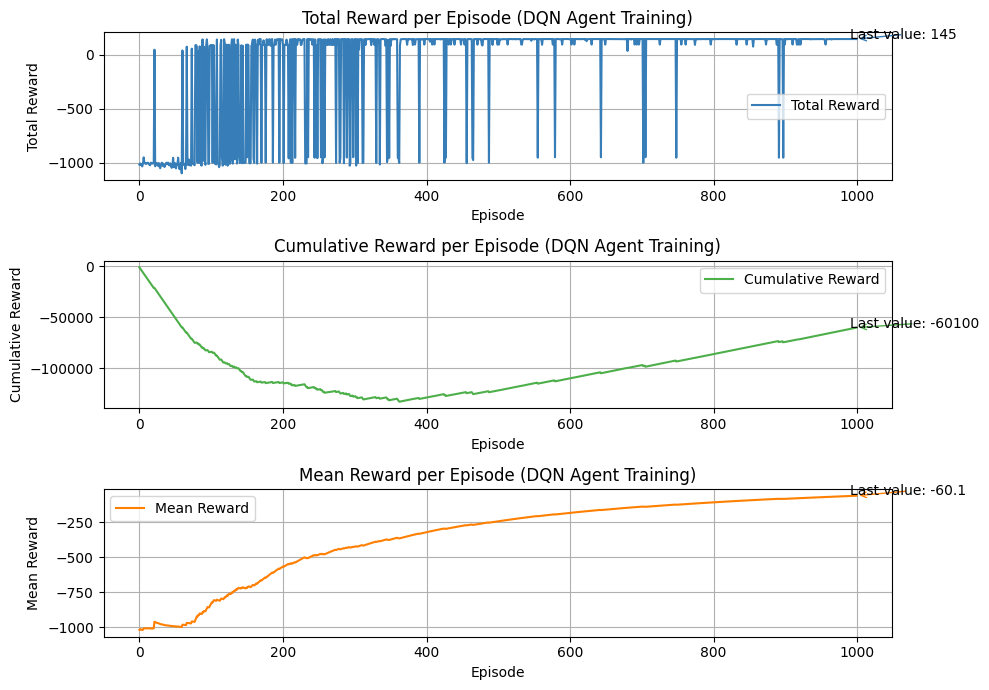

In [ ]:
# Initialize the environment
env = GridEnvironment()

# Define hyperparameters
learning_rate = 1e-4
gamma = 0.99
state_shape = (env.size * env.size * 5,)
actions = 8             # 4 for moving, 4 for shooting
batch_size = 64

# Create the agent
agent = DQNAgent(learning_rate, gamma, state_shape, actions, batch_size)

# Train the agent
episodes = 1000
total_rewards, cumulative_rewards, mean_rewards = agent.train(env, episodes)

# Plot the results
plot_rewards(total_rewards, cumulative_rewards, mean_rewards, "DQN Agent Training", "dqn_training_rewards.png")

# DQN results for comparison:
DQNtotal_rewards = total_rewards
DQNcumulative_rewards = cumulative_rewards
DQNmean_rewards = mean_rewards

##PLots

In [ ]:
import matplotlib.pyplot as plt

def plot_rewards(dqn_rewards, dqn_cumulative, dqn_mean, title, filename):
    # Create subplots with specified figure size
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))

    # Plot Total Reward per Episode
    axs[0].plot(dqn_rewards, label='DQN Total Reward', color='tab:brown')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode ({title})')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Cumulative Reward per Episode
    axs[1].plot(dqn_cumulative, label='DQN Cumulative Reward', color='tab:red')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Cumulative Reward')
    axs[1].set_title(f'Cumulative Reward per Episode ({title})')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Mean Reward per Episode
    axs[2].plot(dqn_mean, label='DQN Mean Reward', color='tab:brown')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Mean Reward')
    axs[2].set_title(f'Mean Reward per Episode ({title})')
    axs[2].legend()
    axs[2].grid(True)

    # Adjust layout to prevent overlap of titles and labels
    plt.tight_layout()

    # Save the plot as an image file
    plt.savefig(filename)

    # Display the plot
    plt.show()

# Example usage: Plotting Q-Learning vs DQN training rewards
plot_rewards(Qtotal_rewards, Qcumulative_rewards, Qmean_rewards,
             DQNtotal_rewards, DQNcumulative_rewards, DQNmean_rewards,
             "Q-Learning vs DQN Training", "qlearning_vs_dqn_training_rewards.png")

NameError: name 'Qtotal_rewards' is not defined